# Verhinderung von auslaufenden Markierungen
Ein häufiges Problem bei der Segmentierung von Zellen in Bildern mit Membranfärbung sind _auslaufende_ Markierungen. Bei der Verwendung von Algorithmen wie dem [Seeded Watershed]() können diese Ausläufer durch Filtern des Bildes verhindert werden, z.B. durch Verwendung eines lokalen Maximum-Filters.

In [1]:
import napari_segment_blobs_and_things_with_membranes as nsbatwm
from skimage.data import cells3d
import stackview
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

Zu Demonstrationszwecken verwenden wir das [cells3d-Beispielbild von scikit-image](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.cells3d).

In [2]:
image = cells3d()[:,0]
image.shape

(60, 256, 256)

Wir betrachten einen Schnitt davon in Z-Y. Der Einfachheit halber lassen wir nach dieser Abbildung die Achsenbeschriftungen im Code weg.

Text(0, 0.5, 'Z')

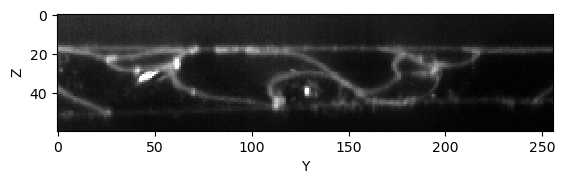

In [3]:
cle.imshow(image[:,:,128], max_display_intensity=20000, continue_drawing=True)
plt.xlabel("Y")
plt.ylabel("Z")

Wenn wir den Seeded-Watershed-Algorithmus auf diesen Datensatz anwenden (in 3D), können wir sehen, dass einige Markierungen in Z auslaufen. Sie verschmelzen mit dem Bereich außerhalb der Gewebeschicht.

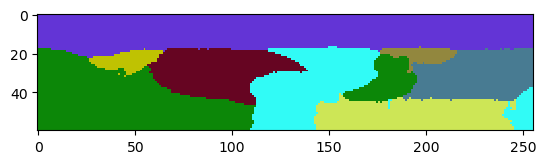

In [4]:
reference_labels = nsbatwm.local_minima_seeded_watershed(image, spot_sigma=9)

cle.imshow(reference_labels[:,:,128], labels=True)

Das Problem kann reduziert werden, indem man einen Maximum-Filter auf das Rohbild anwendet. Dies führt zu dickeren Membranen und damit zu einer geringeren Wahrscheinlichkeit, dass der Watershed-Algorithmus durch Löcher in der Membran auslaufen kann.

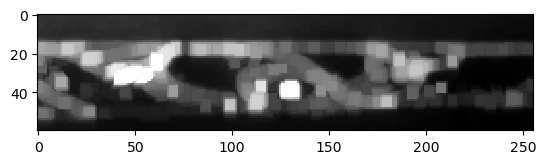

In [5]:
thicker_membranes = nsbatwm.maximum_filter(image, radius=2)

cle.imshow(thicker_membranes[:,:,128], max_display_intensity=20000)

Das resultierende Markierungsbild hat weniger auslaufende Markierungen, hat aber auch an Genauigkeit der Markierungsgrenzen in alle Richtungen verloren.

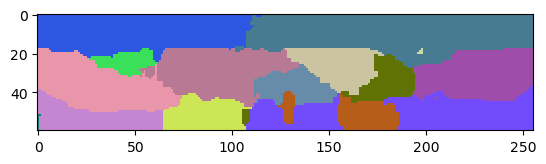

In [6]:
labels1 = nsbatwm.local_minima_seeded_watershed(thicker_membranes, spot_sigma=9)

cle.imshow(labels1[:,:,128], labels=True)

Die Ausläufer scheinen oft nur in Z-Richtung aufzutreten, was ein Effekt der [Punktspreizfunktion](https://de.wikipedia.org/wiki/Punktspreizfunktion) gängiger Mikroskopietechniken ist. Sie ist typischerweise anisotrop, und daher kann das Mikroskop die Membranen in Z nicht so gut erfassen wie in X und Y.

Um dieses Problem der auslaufenden Markierungen nur in X und Y zu behandeln und etwas von der Genauigkeit in Z zu bewahren, müssen wir einen Maximum-Filter anwenden, bei dem wir unterschiedliche Radien in X, Y und Z angeben können.

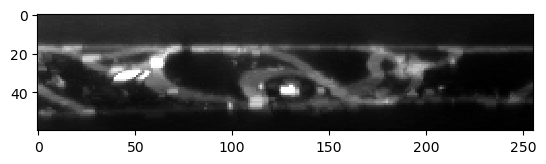

In [7]:
thinker_membranes_in_x_y = cle.maximum_sphere(image, radius_x=2, radius_y=2, radius_z=0)

cle.imshow(thinker_membranes_in_x_y[:,:,128], max_display_intensity=20000)

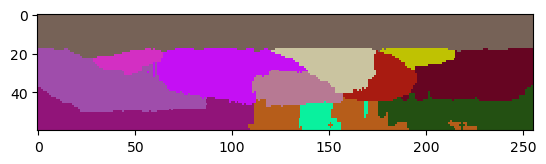

In [8]:
labels2 = nsbatwm.local_minima_seeded_watershed(thinker_membranes_in_x_y, spot_sigma=9)

cle.imshow(labels2[:,:,128], labels=True)

## Ausschluss von Markierungen an Bildrändern in Z
Bilder einzelner Gewebeschichten werden üblicherweise so aufgenommen, dass wir einige Pixel und später segmentierte Markierungen außerhalb des oberen und unteren Gewebes (in Z) sehen. Wir können diese Markierungen entfernen, während wir diejenigen, die den Bildrand in X und Y berühren, explizit beibehalten.

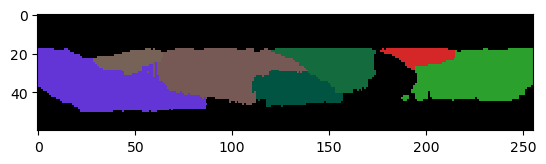

In [9]:
corrected_labels = cle.exclude_labels_on_edges(labels2, 
                                               exclude_in_x=False, 
                                               exclude_in_y=False, 
                                               exclude_in_z=True)

cle.imshow(corrected_labels[:,:,128], labels=True)

Offensichtlich verlieren wir immer noch eine Zelle, die in den Bereich unterhalb des Gewebes ausgelaufen ist. Es könnte jedoch unmöglich sein, ein perfektes Ergebnis zu erzielen.